# Final Report: Classifying Pulsars
Authors: Rico, Iqbal, Kimmy, Hank, Haonan, Bhavya

## Introduction
   A pulsar is a Neutron star, remnants from a supernova explosion. Pulsars are characterized by their blinking light or periodic pulse of radio waves, rapid rotation, and strong magnetic field(Cofield, 2016 ). Because these are among the densest materials on Earth, Physicists study these to identify the presence of alien planets, detect gravitational waves, calculate cosmic distances, and test the universal force of gravity. Moreover, when two pulsars are nearby, there will be a collision and a larger explosion (Mahony, 2020). 

   Each potential detection is represented by two curves:  the integrated profile and DM-SNR. Since a pulsar periodically emits unique pulses, the integrated profile is used to represent an average of these different pulses (Lyon, 2016). To describe the uncertainty caused by dispersion (where each pulse is detected at different times across frequencies), a dispersion-measure-signal-to-noise (DM-SNR) curve is used. Furthermore, each curve is described by four statistical variables: mean, standard deviation, kurtosis, and skewness.

   In reality, most candidates are caused by radio frequency interference and noise, consequently making positive pulsar cases rare to detect. Hence, our goal for this project is to train a model that classifies whether a star is non-pulsar or pulsar star based on the mean, standard deviation, kurtosis, and skewness of the integrated profile. Our central question is:  can we determine whether the signal is coming from a pulsar star or not?

   To explore this, the group will analyze a total of 17,898 radio pulses by the High time Resolution Universe Survey (HTRU) by Dr. Robert Lyon of the Royal Astronomical Society. 




![](https://media3.giphy.com/media/l3dj5M4YLaFww31V6/giphy.gif)

## Methods and Results

In [33]:
# Install packages
# install.packages('tidyverse')
# install.packages('tidymodels')
# install.packages('gridExtra')
install.packages('themis')
install.packages('caret')

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [34]:
# Import packages
library(tidyverse)
library(tidymodels)
library(themis)
library(caret)

In [35]:
# Read csv file 
# Source: https://archive.ics.uci.edu/ml/datasets/HTRU2
htru_data <- read_csv('https://raw.githubusercontent.com/iaujla01/DSCI100Project/main/data/HTRU_2.csv', col_names = FALSE)

# Adding column names: 
# 1. Mean of the integrated profile
# 2. Standard deviation of the integrated profile
# 3. Excess kurtosis of the integrated profile 
# 4. Skewness of the integrated profile
# 5. Mean of the DM-SNR curve
# 6. Standard deviation of the DM-SNR curve
# 7. Excess kurtosis of the DM-SNR curve
# 8. Skewness of the DM-SNR curve
# 9. Class
colnames(htru_data) <- c('mean_ip', 'sd_ip', 'kurtosis_ip', 'skew_ip', 'mean_dmsnr', 'sd_dmsnr', 'kurtosis_dmsnr', 'skew_dmsnr', 'class')
htru_data <- htru_data %>% 
    mutate(class = as.factor(class)) # since class is a dummy variable that is either positive (1) or negative (0)
head(htru_data)

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double()
)



mean_ip,sd_ip,kurtosis_ip,skew_ip,mean_dmsnr,sd_dmsnr,kurtosis_dmsnr,skew_dmsnr,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,0


### Splitting Our Dataset

In [36]:
# Picked seed 3456 for reproducible results
set.seed(3456)

# 17,898 total examples; 1,639 positive examples; 16,259 negative examples
# Decided to split dataset into 75% training and 25% testing
 recipe_upsample <- recipe(class ~ mean_ip + sd_ip + kurtosis_ip + skew_ip, data = htru_data) %>%
                     step_upsample(class, over_ratio = 1, skip = FALSE)

 htru_upscaled <- recipe_upsample %>%
                 prep() %>%
                 bake(htru_data)
 group_by(htru_upscaled, class) %>%
 summarize(n = n())
htru_split <- initial_split(htru_upscaled, prop = 0.75, strata = class)
htru_train <- training(htru_split)
htru_test <- testing(htru_split)

glimpse(htru_train)
glimpse(htru_test)


`summarise()` ungrouping output (override with `.groups` argument)



class,n
<fct>,<int>
0,16259
1,16259


Rows: 24,390
Columns: 5
$ mean_ip     <dbl> 140.56250, 103.01562, 136.75000, 88.72656, 93.57031, 130.…
$ sd_ip       <dbl> 55.68378, 39.34165, 57.17845, 40.67223, 46.69811, 39.8440…
$ kurtosis_ip <dbl> -0.23457141, 0.32332837, -0.06841464, 0.60086608, 0.53190…
$ skew_ip     <dbl> -0.69964840, 1.05116443, -0.63623837, 1.12349169, 0.41672…
$ class       <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
Rows: 8,128
Columns: 5
$ mean_ip     <dbl> 102.50781, 119.48438, 107.25781, 95.86719, 106.64844, 119…
$ sd_ip       <dbl> 58.88243, 48.76506, 39.49649, 42.05992, 56.36718, 52.8748…
$ kurtosis_ip <dbl> 0.465318154, 0.031460220, 0.465881961, 0.326386917, 0.378…
$ skew_ip     <dbl> -0.5150879, -0.1121676, 1.1628771, 0.8035018, -0.2663716,…
$ class       <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …


### Preliminary Summary

In [37]:
positive_candidates <- htru_train %>% 
    group_by(class) %>% 
    summarize(n = n())
positive_candidates

htru_proportions <- htru_train %>%
    group_by(class) %>%
    summarize(n = n()) %>%
    mutate(percent = 100 * n / nrow(htru_train))
htru_proportions

# Looking at figure xxx, we can see that there are 1226 positive pulsar candidates in the training data 

mean_htru_train<- htru_train %>% 
    group_by(class) %>% 
    summarize(max_mean_ip = max(mean_ip, na.rm = TRUE),
             max_sd_ip = max(sd_ip, na.rm = TRUE),
             max_kurtosis_ip = max(kurtosis_ip, na.rm = TRUE),
             max_skew_ip = max(skew_ip, na.rm = TRUE),
             min_mean_ip = min(mean_ip, na.rm = TRUE),
             min_sd_ip = min(sd_ip, na.rm = TRUE),
             min_kurtosis_ip = min(kurtosis_ip, na.rm = TRUE),
             min_skew_ip = min(skew_ip, na.rm = TRUE)) %>%
             pivot_longer(cols = -class,
                 names_to = 'variable_max_min',
                 values_to = 'Value') 
mean_htru_train
# At the beginning of the study, it was reasonable to consider that the critical points (extremes) of these data 
# could be correlated with whether or not they were judged to be pulsars
  

`summarise()` ungrouping output (override with `.groups` argument)



class,n
<fct>,<int>
0,12195
1,12195


`summarise()` ungrouping output (override with `.groups` argument)



class,n,percent
<fct>,<int>,<dbl>
0,12195,50
1,12195,50


`summarise()` ungrouping output (override with `.groups` argument)



class,variable_max_min,Value
<fct>,<chr>,<dbl>
0,max_mean_ip,190.42187500
0,max_sd_ip,98.77891067
0,max_kurtosis_ip,4.78578590
0,max_skew_ip,24.87242875
0,min_mean_ip,27.60156250
0,min_sd_ip,28.69871445
0,min_kurtosis_ip,-1.73078172
0,min_skew_ip,-1.79188598
1,max_mean_ip,139.25781250


### Preliminary Visualization

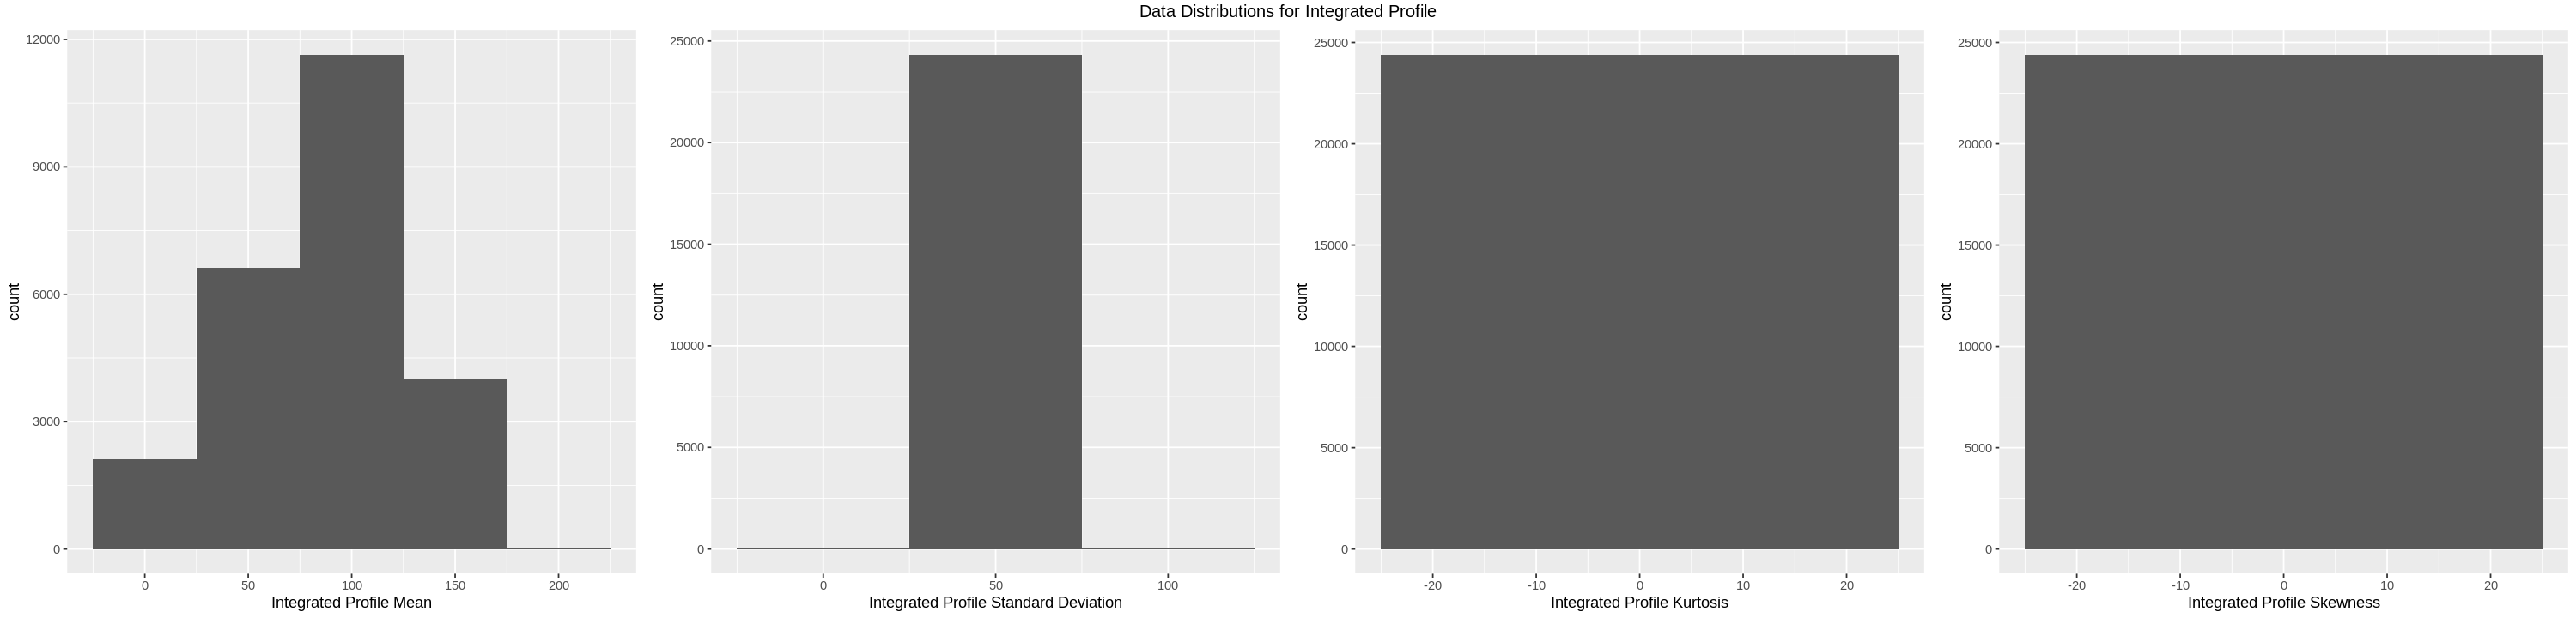

In [38]:
library(gridExtra) # package used to arrange plots neatly in a grid
options(repr.plot.width = 25, repr.plot.height = 6)

vis_mean_ip <- ggplot(htru_train, aes(x = mean_ip)) +
    geom_histogram(binwidth = 50) + 
    labs(x = 'Integrated Profile Mean')
vis_sd_ip <- ggplot(htru_train, aes(x = sd_ip)) +
    geom_histogram(binwidth = 50) + 
    labs(x = 'Integrated Profile Standard Deviation')
vis_kurtosis_ip <- ggplot(htru_train, aes(x = kurtosis_ip)) +
    geom_histogram(binwidth = 50) + 
    labs(x = 'Integrated Profile Kurtosis')
vis_skew_ip <- ggplot(htru_train, aes(x = kurtosis_ip)) +
    geom_histogram(binwidth = 50) + 
    labs(x = 'Integrated Profile Skewness')

grid.arrange(vis_mean_ip, vis_sd_ip, vis_kurtosis_ip, vis_skew_ip, nrow = 1, top = 'Data Distributions for Integrated Profile')

### Building and Training Our Classifier Model

In [39]:
# set.seed(3456)
# recipe_upsample <- recipe(class ~ mean_ip + sd_ip + kurtosis_ip + skew_ip, data = htru_data) %>%
#                     step_upsample(class, over_ratio = 1, skip = FALSE)

# htru_train2 <- recipe_upsample %>%
#                 prep() %>%
#                 bake(htru_train)
# group_by(htru_train2, class) %>%
# summarize(n = n())

In [40]:
set.seed(3456)  
 
# Setting up tuning model
htru_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
                              set_engine("kknn") %>%
                              set_mode("classification")

# Creating preprocessing recipe
htru_recipe <- recipe(class ~ mean_ip + sd_ip + kurtosis_ip + skew_ip, data = htru_train) %>%
               step_scale(all_predictors()) %>%
               step_center(all_predictors())

In [41]:
set.seed(3456)  

# Performing cross-validation 
htru_vfold <- vfold_cv(htru_train, v = 5, strata = class)
# Have tried more folds, but no statically significant results 
gridvals <- tibble(neighbors = 1:14) # Picked 14 neighbors to test (inadequate computer power to test more)

htru_results <- workflow() %>%
                add_recipe(htru_recipe) %>%
                add_model(htru_tune) %>%
                tune_grid(resamples = htru_vfold, grid = gridvals) %>%
                collect_metrics() %>% 
                filter(.metric == "accuracy")
htru_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9865519,5,0.0006848419,Model01
2,accuracy,binary,0.9865519,5,0.0006848419,Model02
3,accuracy,binary,0.9760148,5,0.0009980042,Model03
4,accuracy,binary,0.9760148,5,0.0009980042,Model04
5,accuracy,binary,0.9662977,5,0.0006909512,Model05
6,accuracy,binary,0.9662977,5,0.0006909512,Model06
7,accuracy,binary,0.9578926,5,0.0009496708,Model07
8,accuracy,binary,0.9578926,5,0.0009496708,Model08
9,accuracy,binary,0.9496515,5,0.0014705950,Model09


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9865519,5,0.0006848419,Model01


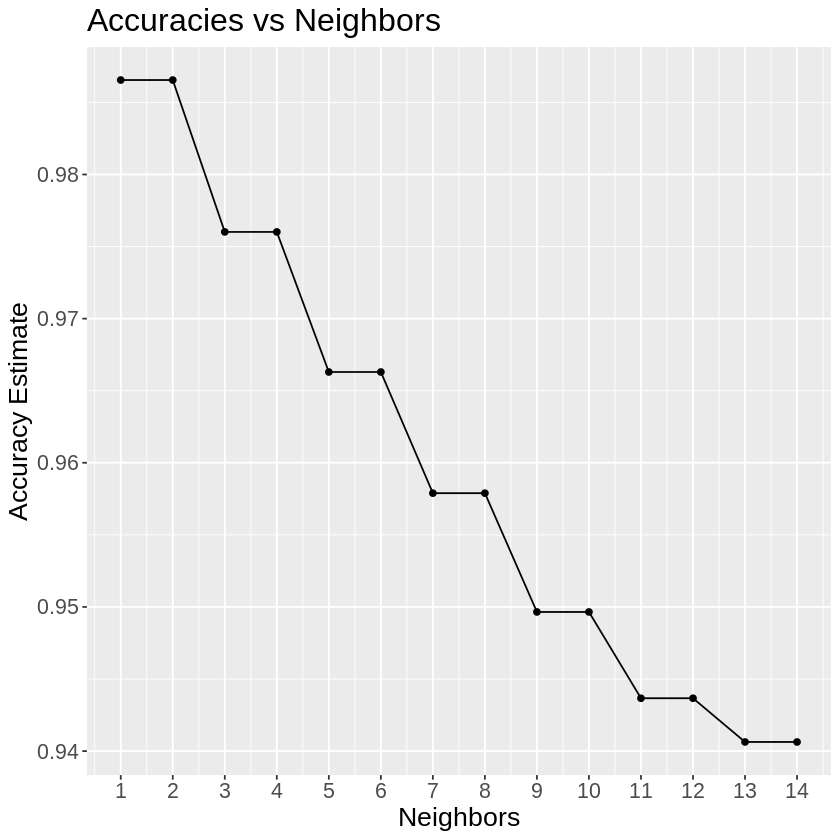

In [42]:
set.seed(3456)  

options(repr.plot.width = 7, repr.plot.height = 7)

# Finding the number of neighbors that yields the highest accuracy (mean)
k_max <- htru_results %>%
    arrange(desc(mean)) %>% 
    slice(1)
k_max

# Plotting accuracy against neighbors
accuracies_vs_k  <- ggplot(htru_results, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       ggtitle('Accuracies vs Neighbors') +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 14, 1)) + 
       theme(text = element_text(size = 16))
accuracies_vs_k

In [43]:
set.seed(3456)  

k_best <- k_max %>% 
    pull(neighbors)

# Specifying model using best number of neighbors
htru_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_best) %>%
  set_engine("kknn") %>%
  set_mode("classification")

# Fitting our model to the training data
htru_fit <- workflow() %>%
  add_recipe(htru_recipe) %>%
  add_model(htru_spec) %>%
  fit(data = htru_train)

# Evaluating our model with the testing data
htru_predictions <- htru_fit %>%
  predict(htru_test) %>%
  bind_cols(htru_test) %>%
  metrics(truth = class, estimate = .pred_class) %>%
  filter(.metric == 'accuracy')
htru_predictions

htru_matrix <- htru_fit %>% 
    predict(htru_test) %>% 
    bind_cols(htru_test) %>%
    conf_mat(truth = class, estimate = .pred_class)
htru_matrix


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9875738


          Truth
Prediction    0    1
         0 3963    0
         1  101 4064

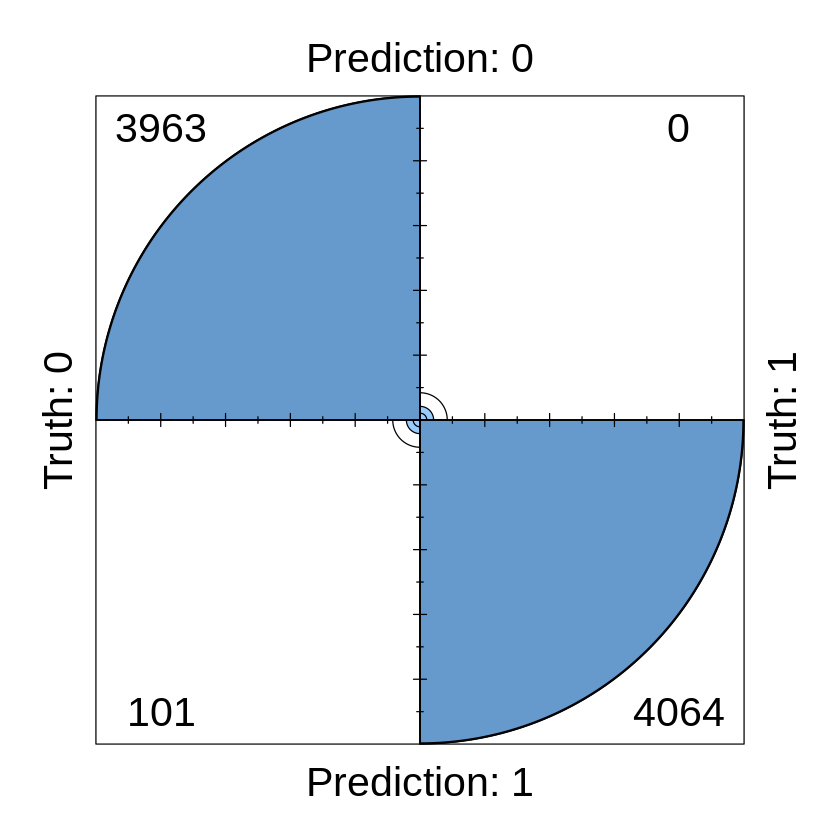

In [44]:
fourfoldplot(htru_matrix$table)

mean_ip,sd_ip,kurtosis_ip,skew_ip,class,type
<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
140.56250,55.68378,-0.23457141,-0.69964840,0,training
103.01562,39.34165,0.32332837,1.05116443,0,training
136.75000,57.17845,-0.06841464,-0.63623837,0,training
88.72656,40.67223,0.60086608,1.12349169,0,training
93.57031,46.69811,0.53190485,0.41672112,0,training
130.38281,39.84406,-0.15832276,0.38954045,0,training
107.25000,52.62708,0.45268802,0.17034738,0,training
142.07812,45.28807,-0.32032843,0.28395251,0,training
133.25781,44.05824,-0.08105986,0.11536151,0,training


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



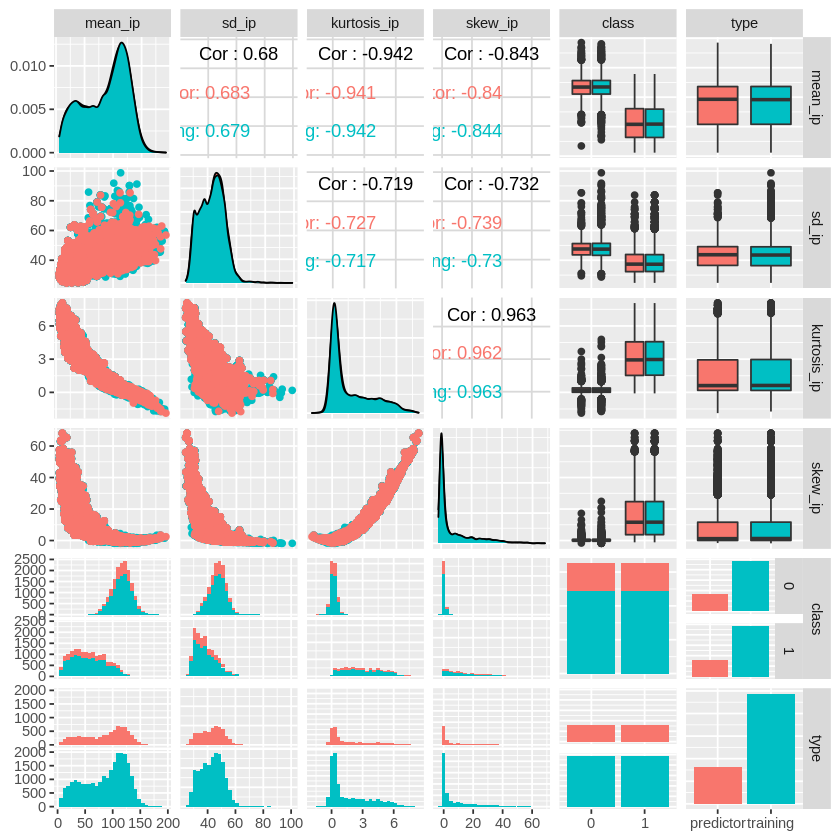

In [44]:
total <- htru_train %>%
mutate(type = "training") 

total2 <- htru_test %>%
mutate(type = "predictor")
combined <- rbind(total, total2)
combined

ggpairs(combined, aes(colour = type))

## Discussion

## References

* UCI Machine Learning Repository: HTRU2 Data Set. (2017). Uci.edu. https://archive.ics.uci.edu/ml/datasets/HTRU2 

* R. J. Lyon, B. W. Stappers, S. Cooper, J. M. Brooke, J. D. Knowles, Fifty Years of Pulsar Candidate Selection: From simple filters to a new principled real-time classification approach, Monthly Notices of the Royal Astronomical Society 459 (1), 1104-1123, DOI: 10.1093/mnras/stw656 

* Cofield, C. (2016, April 22). What Are Pulsars? Space.com; Space. https://www.space.com/32661-pulsars.html   

* Mahoney, T. (2020, July 9). Why Pulsars Are Some of the Most Dangerous Objects in the Universe. Medium; Uncharted Infinity. https://medium.com/uncharted-infinity/why-pulsars-are-some-of-the-most-dangerous-objects-in-the-universe-d54789a00772

* CSC2019 - Introduction to Machine Learning. (2019). Github.io. https://as595.github.io/classification/ 
